In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import numpy as np
import csv
import re

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

/Users/allisonmorgan/Dropbox/Faculty Social Mobility/code/plot_utils.py:39: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [


## Load data

In [2]:
# match = pd.read_csv("../data/coded_data/data_match.csv", low_memory=False)
# match = dict(zip(match.match2, match.match1))

df = pd.read_csv("../data/coded_data/data_cleaned.csv", low_memory=False)
people = pd.read_csv("../data/coded_data/data_people.csv", low_memory=False)

# Change df match column to link with people
# df['match1'] = df['match2'].map(match)

In [3]:
people['likely_department'].value_counts()

Biology                     1557
Business                    1293
Psychology                  1145
Computer Science            1139
Physics and/or Astronomy    1063
History                      992
Sociology                    523
Anthropology                 400
Name: likely_department, dtype: int64

In [4]:
people.shape, sum(people['Childhood Zipcode'].notna()), \
 sum(df['Parent 1 Education'].notna()), sum(df['Career Support from Family'].notna())

((8139, 71), 4807, 7347, 6984)

In [5]:
people['zip_1'] = people['Childhood Zipcode'].apply(lambda x: str(x).split(r',')[0].strip())
cs_indicator = people['likely_department'] == 'Computer Science'
people.loc[cs_indicator, 'zip_1'] = people.loc[cs_indicator, 'zip-original'].apply(
    lambda x: str(x).split(r',')[0].strip())

In [6]:
 # Some zipcode data was converted to numeric and the first zero was dropped
missing_front_zero = (people['zip_1'].str.len() == 4)
print(list(people.loc[missing_front_zero, 'zip_1']))
people.loc[missing_front_zero, 'zip_1'] = people.loc[missing_front_zero, 'zip_1'].apply(lambda x: '0%s' % x)
print(list(people.loc[missing_front_zero, 'zip_1']))

['9005', '6020', '6810', '2119', '7652', '7079', '7652', '8865', '8540', '2124', '8344', '2124', '6460', '2154', '6851', '2159', '6770', '1002', '2864', '8534', '2090', '1730', '7730', '8812', '7039', '7410', '7081', '1532', '6840', '6850', '7960', '7869', '7746', '2459', '1463', '3257', '1720', '7042', '6360', '2806', '2481', '5461', '8033', '7677', '1827', '6614', '8820', '5452', '3301', '8525', '7401', '7078', '1757', '2167', '1960', '1001', '1720', '2020', '1130', '4054']
['09005', '06020', '06810', '02119', '07652', '07079', '07652', '08865', '08540', '02124', '08344', '02124', '06460', '02154', '06851', '02159', '06770', '01002', '02864', '08534', '02090', '01730', '07730', '08812', '07039', '07410', '07081', '01532', '06840', '06850', '07960', '07869', '07746', '02459', '01463', '03257', '01720', '07042', '06360', '02806', '02481', '05461', '08033', '07677', '01827', '06614', '08820', '05452', '03301', '08525', '07401', '07078', '01757', '02167', '01960', '01001', '01720', '0202

In [7]:
people['Birth Year'].dropna().describe()

count    7342.000000
mean     1966.805503
std        12.258768
min      1916.000000
25%      1957.000000
50%      1968.000000
75%      1977.000000
max      1999.000000
Name: Birth Year, dtype: float64

In [8]:
# Scale USNWR / NRC by the maximum for each field.
people['USNWR'] = pd.to_numeric(people['USNWR'])
people['NRC'] = pd.to_numeric(people['NRC'])

max_dept_usnwr = people.groupby(['likely_department'])['USNWR'].max()
max_dept_nrc = people.groupby(['likely_department'])['NRC'].max()

def rank_scalar(row):
    if (row['likely_department'] in max_dept_usnwr) and not np.isnan(max_dept_usnwr[row['likely_department']]):
        return 100*np.divide(row['USNWR'], max_dept_usnwr[row['likely_department']])
    elif (row['likely_department'] in max_dept_nrc) and not np.isnan(max_dept_nrc[row['likely_department']]):
        return 100*np.divide(row['NRC'], max_dept_nrc[row['likely_department']])
    else:
        return np.nan

people['rank_scaled'] = people.apply(rank_scalar, axis=1)

In [9]:
people.groupby(['likely_department'])['rank_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
likely_department,,,,,,,,
Anthropology,334.0,35.305066,28.820336,1.351351,13.513514,23.648649,58.108108,100.0
Biology,1409.0,35.454449,26.091456,0.425532,14.042553,26.382979,55.319149,100.0
Business,1121.0,42.853152,27.793939,1.010101,19.191919,40.404040,62.626263,100.0
Computer Science,983.0,35.329636,25.413205,0.537634,13.440860,32.795699,54.838710,100.0
History,935.0,40.466558,28.293230,0.724638,16.666667,31.884058,65.942029,100.0
Physics and/or Astronomy,981.0,35.302948,27.233818,0.684932,11.643836,25.342466,48.630137,100.0
Psychology,1024.0,38.424359,27.593131,0.460829,16.589862,34.562212,60.368664,100.0
Sociology,455.0,38.401207,26.449864,0.980392,16.666667,35.294118,55.882353,100.0


In [10]:
temp = people.copy()
temp['rank_scaled_missing'] = temp['rank_scaled'].isna()
print('ALL: ', temp['rank_scaled_missing'].mean())
temp.groupby(['likely_department'])['rank_scaled_missing'].mean()

ALL:  0.11021009952082565


likely_department
Anthropology                0.165000
Biology                     0.095055
Business                    0.133024
Computer Science            0.136962
History                     0.057460
Physics and/or Astronomy    0.077140
Psychology                  0.105677
Sociology                   0.130019
Name: rank_scaled_missing, dtype: float64

In [11]:
people[people['likely_department'].isin([
    'Computer Science','History','Business', 'Psychology','Physics and/or Astronomy',
    'Sociology', 'Anthropology'
])].describe()

,PhD Year,Tenure Track Year,Birth Year,u_gender,u_firstname,sid,white,hisp,black,asian,...,phd_USNWR,NRC,phd_NRC,age (actual),zip1,zip2,abroad_fin,location_more,match,rank_scaled
count,4637.000000,5584.000000,5764.000000,4727.0,0.0,1139.000000,6555.000000,6555.000000,6555.000000,6555.000000,...,3482.000000,334.000000,299.000000,1127.000000,1113.000000,19.000000,233.0,10.0,6555.000000,5833.000000
mean,1997.534829,2000.412428,1967.210271,0.0,NaN,572.596137,-7.811594,-8.492143,-8.502517,-8.436003,...,26.143596,26.125749,12.973244,48.685892,17589.215633,35268.263158,1.0,1.0,4063.429138,38.375934
std,12.775840,12.740266,12.439987,0.0,NaN,330.827352,24.422404,24.180074,24.176213,24.200881,...,32.048675,21.327049,15.318956,12.086089,28649.042334,26661.302043,0.0,0.0,2356.646395,27.452193
min,1953.000000,1928.000000,1916.000000,0.0,NaN,1.000000,-77.000000,-77.000000,-77.000000,-77.000000,...,1.000000,1.000000,1.000000,26.000000,0.000000,6470.000000,1.0,1.0,0.000000,0.460829
25%,1988.000000,1991.000000,1958.000000,0.0,NaN,286.500000,0.000000,0.000000,0.000000,0.000000,...,5.000000,10.000000,2.000000,38.000000,0.000000,17678.500000,1.0,1.0,2028.500000,15.753425
50%,1999.000000,2002.000000,1968.000000,0.0,NaN,573.000000,1.000000,0.000000,0.000000,0.000000,...,14.000000,17.500000,10.000000,48.000000,0.000000,30752.000000,1.0,1.0,4055.000000,32.191781
75%,2008.000000,2012.000000,1978.000000,0.0,NaN,857.500000,1.000000,0.000000,0.000000,0.000000,...,37.000000,43.000000,16.000000,58.000000,23111.000000,42313.500000,1.0,1.0,6112.500000,57.246377
max,2018.000000,2020.000000,1996.000000,0.0,NaN,1147.000000,1.000000,1.000000,1.000000,1.000000,...,217.000000,74.000000,74.000000,85.000000,99738.000000,99712.000000,1.0,1.0,8138.000000,100.000000


In [12]:
for dpt in people.likely_department.dropna().unique():
    print(dpt, dict(people[people.likely_department == dpt]['Tenure Track Year'].isna().value_counts()))

Business {False: 995, True: 298}
History {False: 875, True: 117}
Computer Science {False: 1059, True: 80}
Anthropology {False: 347, True: 53}
Physics and/or Astronomy {False: 916, True: 147}
Psychology {False: 960, True: 185}
Sociology {False: 432, True: 91}
Biology {False: 1511, True: 46}


In [13]:
people['Tenure Track Year'].isna().value_counts()

False    7121
True     1018
Name: Tenure Track Year, dtype: int64

In [14]:
people['PhD Year'].isna().value_counts()

False    6208
True     1931
Name: PhD Year, dtype: int64

## Linking responses to national data

First, let's find the appropriate data set to match individuals to depending on when they were born. The goal is to get estimates of geographic / economic diversity of professors’ upbringing, so we need to basically best approximate what the world was like during the first 21 years of their lives. 

Census data dates back to 1990, IRS to 1998, and NSF SED to 1993. In some cases, older faculty will be matched to the oldest available data set. We should test whether dropping these individuals changes these results significantly.

### Finding closest appropriate year

In [15]:
census_data_years = np.array([1990, 2000, 2010])

absolute_val_array = people['Birth Year'].apply(lambda x: np.abs(census_data_years - (x + 21)))
# smallest_difference_val = absolute_val_array.apply(lambda x: x.min())
smallest_difference_index = absolute_val_array.apply(lambda x: x.argmin())
closest_element = smallest_difference_index.apply(lambda x: census_data_years[x])

people['closest_ruca_year'] = closest_element
print(people.groupby(['closest_ruca_year'])['Birth Year'].agg(
    ['mean', 'min', 'max', 'count']).to_latex(float_format="%.0f"))

\begin{tabular}{lrrrr}
\toprule
{} &  mean &  min &  max &  count \\
closest\_ruca\_year &       &      &      &        \\
\midrule
1990              &  1960 & 1916 & 1974 &   4985 \\
2000              &  1979 & 1975 & 1984 &   1978 \\
2010              &  1987 & 1985 & 1999 &    379 \\
\bottomrule
\end{tabular}



In [16]:
people['closest_ruca_year'].value_counts(normalize=True)

1990    0.710407
2000    0.243027
2010    0.046566
Name: closest_ruca_year, dtype: float64

In [17]:
irs_data_years = np.array([1998, 2001, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 
                           2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

absolute_val_array = people['Birth Year'].apply(lambda x: np.abs(irs_data_years - (x + 21)))
# smallest_difference_val = absolute_val_array.apply(lambda x: x.min())
smallest_difference_index = absolute_val_array.apply(lambda x: x.argmin())
closest_element = smallest_difference_index.apply(lambda x: irs_data_years[x])

people['closest_irs_year'] = closest_element
print(people.groupby(['closest_irs_year'])['Birth Year'].agg([
    'mean', 'min', 'max', 'count']).to_latex(float_format="%.0f"))

\begin{tabular}{lrrrr}
\toprule
{} &  mean &  min &  max &  count \\
closest\_irs\_year &       &      &      &        \\
\midrule
1998             &  1963 & 1916 & 1978 &   5802 \\
2001             &  1980 & 1979 & 1980 &    394 \\
2002             &  1981 & 1981 & 1982 &    422 \\
2004             &  1983 & 1983 & 1983 &    177 \\
2005             &  1984 & 1984 & 1984 &    168 \\
2006             &  1985 & 1985 & 1985 &    118 \\
2007             &  1986 & 1986 & 1986 &    111 \\
2008             &  1987 & 1987 & 1987 &     61 \\
2009             &  1988 & 1988 & 1988 &     44 \\
2010             &  1989 & 1989 & 1989 &     25 \\
2011             &  1990 & 1990 & 1990 &     11 \\
2012             &  1991 & 1991 & 1991 &      4 \\
2013             &  1992 & 1992 & 1992 &      1 \\
2017             &  1996 & 1996 & 1996 &      2 \\
2019             &  1999 & 1999 & 1999 &      2 \\
\bottomrule
\end{tabular}



In [18]:
nsf_sed_years = np.array([1993, 1998, 2003, 2008, 2013, 2018])

absolute_val_array = people['Tenure Track Year'].apply(lambda x: np.abs(nsf_sed_years - x))
smallest_difference_val = absolute_val_array.apply(lambda x: x.min())
smallest_difference_index = absolute_val_array.apply(lambda x: x.argmin())
closest_element = smallest_difference_index.apply(lambda x: nsf_sed_years[x])

people['closest_nsf_sed_year'] = closest_element
print(people.groupby(['closest_nsf_sed_year'])['Tenure Track Year'].agg(
    ['mean', 'min', 'max', 'count']).to_latex(float_format="%.0f"))

\begin{tabular}{lrrrr}
\toprule
{} &  mean &  min &  max &  count \\
closest\_nsf\_sed\_year &       &      &      &        \\
\midrule
1993                 &  1985 & 1928 & 1995 &   2326 \\
1998                 &  1998 & 1996 & 2000 &    868 \\
2003                 &  2003 & 2001 & 2005 &    985 \\
2008                 &  2008 & 2006 & 2010 &    985 \\
2013                 &  2013 & 2011 & 2015 &   1310 \\
2018                 &  2017 & 2016 & 2020 &    647 \\
\bottomrule
\end{tabular}



In [19]:
census_educ_data_years = np.arange(1993, 1997, 1)
print(census_educ_data_years)

absolute_val_array = people['Birth Year'].apply(lambda x: np.abs(census_educ_data_years - x))
smallest_difference_val = absolute_val_array.apply(lambda x: x.min())
smallest_difference_index = absolute_val_array.apply(lambda x: x.argmin())
closest_element = smallest_difference_index.apply(lambda x: census_educ_data_years[x])

people['closest_educ_year'] = closest_element
print(people.groupby(['closest_educ_year'])['Birth Year'].agg(
    ['mean', 'min', 'max', 'count']).to_latex(float_format="%.0f"))

[1993 1994 1995 1996]
\begin{tabular}{lrrrr}
\toprule
{} &  mean &  min &  max &  count \\
closest\_educ\_year &       &      &      &        \\
\midrule
1993              &  1967 & 1916 & 1992 &   7338 \\
1996              &  1998 & 1996 & 1999 &      4 \\
\bottomrule
\end{tabular}



### Merging data based on years

Merging IRS data on income based on year of birth.

In [20]:
# https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
irs_data = pd.read_csv('../data/irs_data/yearly_irs_zip_data.csv', dtype={'ZIPCODE': str}, low_memory=False)
irs_data = irs_data[irs_data['ZIPCODE'].notna()]

irs_data['INFADJ_AGI'] = irs_data['INFADJ_AGI'].astype(float)
irs_data['AGI'] = irs_data['AGI'].astype(float)
irs_data['N'] = irs_data['N'].astype(float)
irs_data['AVG_ADJ_AGI'] = irs_data['INFADJ_AGI']/irs_data['N']

irs_data.head()

,YEAR,STATE,ZIPCODE,N,AGI,INFADJ_AGI,AVG_ADJ_AGI
0,1998,AL,35000,32.0,629.0,1005.0,31.406250
1,1998,AL,35001,84.0,1744.0,2786.0,33.166667
2,1998,AL,35004,2537.0,94515.0,151002.0,59.519905
3,1998,AL,35005,3772.0,121373.0,193912.0,51.408271
4,1998,AL,35006,1352.0,41937.0,67001.0,49.556953


In [21]:
people['avg_income'] = people.merge(irs_data[['YEAR', 'ZIPCODE', 'AVG_ADJ_AGI']], 
                                    right_on=['YEAR', 'ZIPCODE'], left_on=['closest_irs_year', 'zip_1'], 
                                    how='left')['AVG_ADJ_AGI']
print(people[['likely_department', 'avg_income']].groupby(['likely_department']).mean())

                          avg_income
likely_department                   
Anthropology               95.779590
Biology                    91.232892
Business                   89.441130
Computer Science           95.031577
History                   106.437503
Physics and/or Astronomy   92.828903
Psychology                 95.424801
Sociology                  81.292202


Recode parents' education and employment as parents' highest -- the highest degree earned by either parent for each response.

Let's merge [IPUMS](https://www.nhgis.org) data onto our responses. It contains information on total population, "persons by rural/urban status," racial demographics, "housing units by rural/urban status".

In [22]:
ipums_census = pd.read_csv('../data/rural_urban/nhgis0001_ts_geog2010_zcta.csv', header=1, 
                           dtype={'5-Digit ZIP Code Tabulation Area [2000-Present] Code': str})

In [23]:
ruca_columns = ['1990: Persons: Total', '1990: Persons: Urban', '1990: Persons: Urban--Inside urbanized areas',
                '1990: Persons: Urban--Outside urbanized areas (in urban clusters)', '1990: Persons: Rural',
                
                '2000: Persons: Total', '2000: Persons: Urban', '2000: Persons: Urban--Inside urbanized areas',
                '2000: Persons: Urban--Outside urbanized areas (in urban clusters)', '2000: Persons: Rural',
                
                '2010: Persons: Total', '2010: Persons: Urban', '2010: Persons: Urban--Inside urbanized areas',
                '2010: Persons: Urban--Outside urbanized areas (in urban clusters)', '2010: Persons: Rural']

In [24]:
ipums_census[['1990_pct_urban', '1990_pct_urban_ua', '1990_pct_urban_uc', 
              '1990_pct_rural']] = ipums_census[ruca_columns[1:5]].divide(ipums_census[ruca_columns[0]], 
                                                                          axis=0)

In [25]:
ipums_census[['2000_pct_urban', '2000_pct_urban_ua', '2000_pct_urban_uc', 
              '2000_pct_rural']] = ipums_census[ruca_columns[6:10]].divide(ipums_census[ruca_columns[5]], 
                                                                           axis=0)

In [26]:
ipums_census[['2010_pct_urban', '2010_pct_urban_ua', '2010_pct_urban_uc', 
              '2010_pct_rural']] = ipums_census[ruca_columns[11:15]].divide(ipums_census[ruca_columns[10]], 
                                                                            axis=0)

If over half of your population lives in an urban area, than this zip codes is classified as "urban".

In [27]:
ipums_census['1990_ru_class'] = (ipums_census['1990_pct_urban'] > 0.5).map({True: 'urban', False: 'rural'})
ipums_census['2000_ru_class'] = (ipums_census['2000_pct_urban'] > 0.5).map({True: 'urban', False: 'rural'})
ipums_census['2010_ru_class'] = (ipums_census['2000_pct_urban'] > 0.5).map({True: 'urban', False: 'rural'})

In [28]:
ipums_census[['1990_ru_class', '2000_ru_class', '2010_ru_class']].value_counts()

1990_ru_class  2000_ru_class  2010_ru_class
rural          rural          rural            19805
urban          urban          urban            10434
rural          urban          urban             2337
urban          rural          rural              413
dtype: int64

In [29]:
print(dict(ipums_census['1990_ru_class'].value_counts(normalize=True)), 
      dict(ipums_census['2000_ru_class'].value_counts(normalize=True)),
      dict(ipums_census['2010_ru_class'].value_counts(normalize=True)))

{'rural': 0.6711934281124011, 'urban': 0.3288065718875989} {'rural': 0.6128709569856619, 'urban': 0.3871290430143381} {'rural': 0.6128709569856619, 'urban': 0.3871290430143381}


In [30]:
people = people.merge(
    ipums_census[['5-Digit ZIP Code Tabulation Area [2000-Present] Code', '1990_ru_class', 
                  '2000_ru_class', '2010_ru_class']], 
    right_on = ['5-Digit ZIP Code Tabulation Area [2000-Present] Code'], left_on='zip_1', 
    how='left')

people['ru_class'] = people.apply(
    lambda row: row['%d_ru_class' % row['closest_ruca_year']], axis=1)

people['ru_class'].value_counts()

urban    3540
rural     410
Name: ru_class, dtype: int64

In [31]:
people.closest_ruca_year.value_counts()

1990    5782
2000    1978
2010     379
Name: closest_ruca_year, dtype: int64

Merge education information from the U.S. Census and NSF SED as benchmarks.

In [32]:
nsf_sed = pd.read_excel('../data/nsf_sed/nsf20301-tab034.xlsx', skiprows=3, index_col=0)

In [33]:
nsf_sed.columns = ['NSF_SED_' + col.lower().replace(' ', '_') for col in nsf_sed.columns]

In [34]:
people = people.merge(nsf_sed, right_on=['Year'], left_on=['closest_nsf_sed_year'], 
                                        how='left')
# people[['closest_nsf_sed_year', "NSF_SED_research_doctoral_degree"]].head()

In [35]:
us_census_edu = pd.read_csv('../data/us_census_edu/census/overall_edu/us_census_edu_trend.tsv', sep='\t', index_col=0)

In [36]:
us_census_edu.columns = ['US_' + col.lower().replace(':', '').replace(' ', '_') 
                         for col in us_census_edu.columns]
us_census_edu = us_census_edu.div(us_census_edu.sum(axis=1), axis=0)

In [37]:
us_census_edu.head()

,US_elem_1st-4th,US_elem_5th-6th,US_elem_7-8th,US_hs_9th,US_hs_10th,US_hs_11th,US_hs_graduate,US_college_some,US_associate_occupational,US_associate_academic,US_bachelors,US_masters,US_professional_degree,US_doctorate_degree
Year,,,,,,,,,,,,,,
1993,0.014646,0.021531,0.051065,0.024516,0.035374,0.045583,0.355896,0.167445,0.036845,0.027155,0.145964,0.051355,0.013818,0.008806
1994,0.013113,0.022153,0.047321,0.024379,0.035841,0.043296,0.345655,0.174641,0.038697,0.031394,0.148354,0.051364,0.013865,0.009927
1995,0.012507,0.021882,0.043843,0.023967,0.034256,0.041914,0.341226,0.177443,0.038590,0.033307,0.153011,0.053297,0.014677,0.010083
1996,0.012315,0.020788,0.042520,0.024696,0.034704,0.042789,0.337954,0.174483,0.038809,0.033916,0.158583,0.054381,0.014436,0.009626


In [38]:
people = people.merge(us_census_edu, right_on=['Year'], left_on=['closest_educ_year'], how='left')
# people[['closest_educ_year', 'US_doctorate_degree']].head()

## Export data

In [39]:
people.to_csv('../data/coded_data/data_people_linked.csv', index=False)

## Filter rows and save the linked data

In [40]:
# Join on match
df = df.merge(people, on='match')
    
# Rename the columns here
rename_columns = {
    'Childhood Zipcode':'zip', 'Birth Year':'age_coded', 'Parent 1 Employment Status':'p1_empl',
    'Parent 1 Education':'p1_edu', 'Parent 2 Employment Status':'p2_empl', 'Parent 2 Education':'p2_edu',
    'Parent 1 Gender':'p1_gender', 'Parent 2 Gender':'p2_gender', 'Gender':'gender_ans',
    'Career Support from Family':'support_family', 
    'Importance of geographical location in choosing current position':'current_geo',
    'Importance of geographical location in accepting/refusing an offer from another academic institution':'other_geo',
    'Maximum number of scholarly works aiming to get published in next 2 years':'aim_max',
    'Minimum number of scholarly works aiming to get published in next 2 years':'aim_min',
    'Current institution prestige relative to other institutions in field':'inst_prestige'}
df = df.rename(columns=rename_columns)

In [41]:
canadian_universities = ['University of Waterloo', 'University of Alberta', 'University of Western Ontario', 
                         'York University', 'University of Toronto', 'University of Ottawa', 
                         'Carleton University', 'Concordia University, Montreal, Canada', 
                         'University of Calgary', 'McGill University', 'University of Montreal', 
                         'Université de Montréal', 'University of Saskatchewan', 
                         'University of British Columbia', 'University of New Brunswick', 
                         'Memorial University of Newfoundland', 'University of Victoria',
                         "Queen's University, Kingston Ontario", 'Simon Fraser University', 
                         'University of Regina', 'University of Manitoba', 'Dalhousie University', 
                         'McMaster University']

In [42]:
# Drop faculty at Canadian institutions
df['Institution'].isin(canadian_universities).value_counts(normalize=True)
df = df[~df['Institution'].isin(canadian_universities)]
print(df.shape)

(8009, 289)


In [43]:
df.loc[df.aim_max < 0, 'aim_max'] = np.nan
df.loc[df.aim_min < 0, 'aim_min'] = np.nan
df['aim_avg'] = .5*(df.aim_max + df.aim_min)

In [44]:
df['included'] = df['Feel Included by Colleagues in Field'].replace({'5 Very Included': 5, 
                                                                     '1 Very Excluded': 1})
df['liked'] = df['Feel Liked by Colleagues in Field'].replace({'5 Liked': 5, 
                                                               '1 Not Liked': 1})
df['respected'] = df['Feel Respected by Colleagues in Field'].replace({'5 Respected': 5, 
                                                                       '1 Not Respected': 1})

In [45]:
df['house'] = df['Childhood Home']

In [46]:
# Three survey responses provided a tenure-track year which started before the year they were born
df[(df['Tenure Track Year'] - df['age_coded']) < 0][['likely_department', 'age_coded', 'Tenure Track Year']]
indices = df[((df['Tenure Track Year'] - df['age_coded']) < 0)].index
df.loc[indices, 'age_coded'] = np.nan
df.loc[indices, 'Tenure Track Year'] = np.nan

df['Tenure Track Year'].describe()

count    7008.000000
mean     2000.371433
std        12.616915
min      1956.000000
25%      1991.000000
50%      2002.000000
75%      2011.000000
max      2020.000000
Name: Tenure Track Year, dtype: float64

In [47]:
df['support_parents'] = df['Career Support from Parents']
df['support_partner'] = df['Career Support from Partner']
df['support_friends'] = df['Career Support from Friends Outside of Academia'] 
df['support_collsin'] = df['Career Support from Colleagues at your Current Institution']
df['support_collsout'] = df['Career Support from Colleagues at Other Institutions']

In [48]:
df['p1_edu_coded'] = df['p1_edu'].astype('category')
df['p2_edu_coded'] = df['p2_edu'].astype('category')
df['p1_empl_coded'] = df['p1_empl'].astype('category')
df['p2_empl_coded'] = df['p2_empl'].astype('category')

codes = {'Elementary: 0-4 years': 1, 'Elementary: 5-8 years': 2, 'High school: 1-3 years': 3, 
         'High school: 4 years': 4, 'College: 1-3 years': 5, 'College: 4 or more years': 6, 
         "Master’s or professional degree": 7, 'Doctoral degree': 8}

df['p1_edu'] = df['p1_edu'].map(codes)
df['p2_edu'] = df['p2_edu'].map(codes)

In [49]:
mom_edu_coded = [None]*len(df); 
dad_edu_coded = [None]*len(df); 

mom_empl_coded = [None]*len(df); 
dad_empl_coded = [None]*len(df); 

parents_highest_edu = [None]*len(df); 
parents_highest_empl = [None]*len(df); 

# The following is not very inclusive of different family situations.
for i, (_, row) in enumerate(df.iterrows()): 
    if row['p1_gender'] == 'Female':
        mom_edu_coded[i] = row['p1_edu_coded']
        mom_empl_coded[i] = row['p1_empl_coded']
    if row['p2_gender'] == 'Female':
        mom_edu_coded[i] = row['p2_edu_coded']
        mom_empl_coded[i] = row['p2_empl_coded']
       
    if row['p1_gender'] == 'Male':
        dad_edu_coded[i] = row['p1_edu_coded']
        dad_empl_coded[i] = row['p1_empl_coded']
    if row['p2_gender'] == 'Male':
        dad_edu_coded[i] = row['p2_edu_coded']
        dad_empl_coded[i] = row['p2_empl_coded']

temp = df[['p1_edu', 'p2_edu']].copy()
temp.replace([0, 9, 10, -77], np.nan, inplace=True)
parents_highest_edu = temp[['p1_edu', 'p2_edu']].max(axis=1)

temp = df[['p1_empl', 'p2_empl']].copy()
temp.replace([0, 5, 6, -77], np.nan, inplace=True)
parents_highest_empl = temp[['p1_empl', 'p2_empl']].max(axis=1)

In [50]:
df['mom_edu_coded'] = mom_edu_coded
df['dad_edu_coded'] = dad_edu_coded

In [51]:
df['mom_edu_coded'].replace(["Elementary: 0-4 years", "Elementary: 5-8 years"], 
                                          "Elementary: 0-8 years", inplace=True)
df['mom_edu_coded'].replace(['College: 4 or more years'], 'College: 4+ years', inplace=True)
df['mom_edu_coded'].replace(["Master’s or professional degree"], 
                                         "Master's or professional degree", inplace=True)
df['mom_edu_coded'].replace(["Don't know", "Don’t know", "Not applicable / Rather not say"], 
                                         None, inplace=True)

In [52]:
df['dad_edu_coded'].replace(["Elementary: 0-4 years", "Elementary: 5-8 years"], 
                                          "Elementary: 0-8 years", inplace=True)
df['dad_edu_coded'].replace(['College: 4 or more years'], 'College: 4+ years', inplace=True)
df['dad_edu_coded'].replace(["Master’s or professional degree"], 
                                         "Master's or professional degree", inplace=True)
df['dad_edu_coded'].replace(["Don't know", "Don’t know", "Not applicable / Rather not say"], 
                                         None, inplace=True)

In [53]:
df['mom_empl_coded'] = mom_empl_coded
df['dad_empl_coded'] = dad_empl_coded

In [54]:
codes = {1: "Elementary: 0-8 years", 2: "Elementary: 0-8 years", 3: "High school: 1-3 years", 
         4: "High school: 4 years", 5: "College: 1-3 years", 6: "College: 4+ years", 
         7: "Master's or professional degree", 8: "Doctoral degree"}
df['parents_highest_edu'] = parents_highest_edu
df['parents_highest_edu_coded'] = pd.Series(df['parents_highest_edu']).apply(
    lambda x: codes[x] if x in codes else np.nan).astype('category')

In [55]:
codes = {1: "Employed", 2: "Stay-at-home parent", 3: "Could not find a job", 
         4: "Other reason (e.g. retired, illness, ...)"}
df['parents_highest_empl_coded'] = pd.Series(parents_highest_empl).apply(
    lambda x: codes[x] if x in codes else np.nan).astype('category')

In [56]:
respondents_zip = df.copy(deep=True)
respondents_zip = respondents_zip.rename({'zip_1': 'zip'}, axis = 1)
# respondents_zip.head(2)

In [57]:
respondents_zip.shape

(8009, 310)

In [58]:
respondents_zip.to_csv('../data/coded_data/data_linked.csv', index=False)

## Demographics: % women and % Black and Hispanic over time
 - Using the survey data, we can track a proxy of this measure by using faculty birth year or the year the faculty started their first tenure track job. 
 - If any group tends to remain in academia longer than another (men longer than women, for example), then these results will over represent that group in early years, as we are conditioning on faculty still being in academia at the time of the survey

In [59]:
# df = load_in_data()

df.loc[df['Race'] =='Prefer not to say'] = np.nan #leave out those who do not report their race

#Create a boolean 'poc' column that is false if an individual is _only_ white
df['poc'] = np.nan
df.loc[df['Race'] == 'White', 'poc'] = 0
df['poc'] = df['poc'].fillna(1)
df['poc'].value_counts()


#Create a boolean 'poc2' column that is true when black and/or hispanic
df['poc2'] = np.nan
df.loc[df['black'] == 1, 'poc2'] = 1
df.loc[df['hisp'] == 1, 'poc2'] = 1
df.loc[df['native'] == 1, 'poc2'] = 1
df.loc[df['hawaii'] == 1, 'poc2'] = 1

df['poc2'] = df['poc2'].fillna(0)
print(df['poc2'].value_counts(normalize=True))

#Create a boolean 'female & non binary' column
col_name = 'female & non binary'
df[col_name] = np.nan
df.loc[df['gender_ans'] == 'Male', col_name] = 0
df.loc[df['gender_ans'] == 'Female', col_name] = 1
df.loc[df['gender_ans'] == 'Other identity', col_name] = 1
#Leave 'Prefer not to say' folk as nan
df[col_name].value_counts()


#Create a boolean 'female' column
col_name = 'female'
df[col_name] = np.nan
df.loc[df['gender_ans'] == 'Female', col_name] = 1
df.loc[df['gender_ans'] == 'Male', col_name] = 0
df.loc[df['gender_ans'] == 'Other identity', col_name] = 0

#Leave 'Prefer not to say' folk as nan
print(df[col_name].value_counts(normalize=True))

0.0    0.932076
1.0    0.067924
Name: poc2, dtype: float64
0.0    0.635566
1.0    0.364434
Name: female, dtype: float64


In [60]:
#Pull in census data
census_race_data = pd.read_csv('../data/us_census_race/census_race_by_decade.csv')
census_race_data['Frac Black and Hisp'] = (census_race_data['% Black'] + census_race_data['% Hisp'])/100

census_gender_data = pd.read_excel('../data/us_census_gender/census_gender_by_decade.xlsx')
census_gender_data['Frac Female'] = census_gender_data['% Female'] /100
census_gender_data.drop(6, inplace= True)  #drop 1960 data

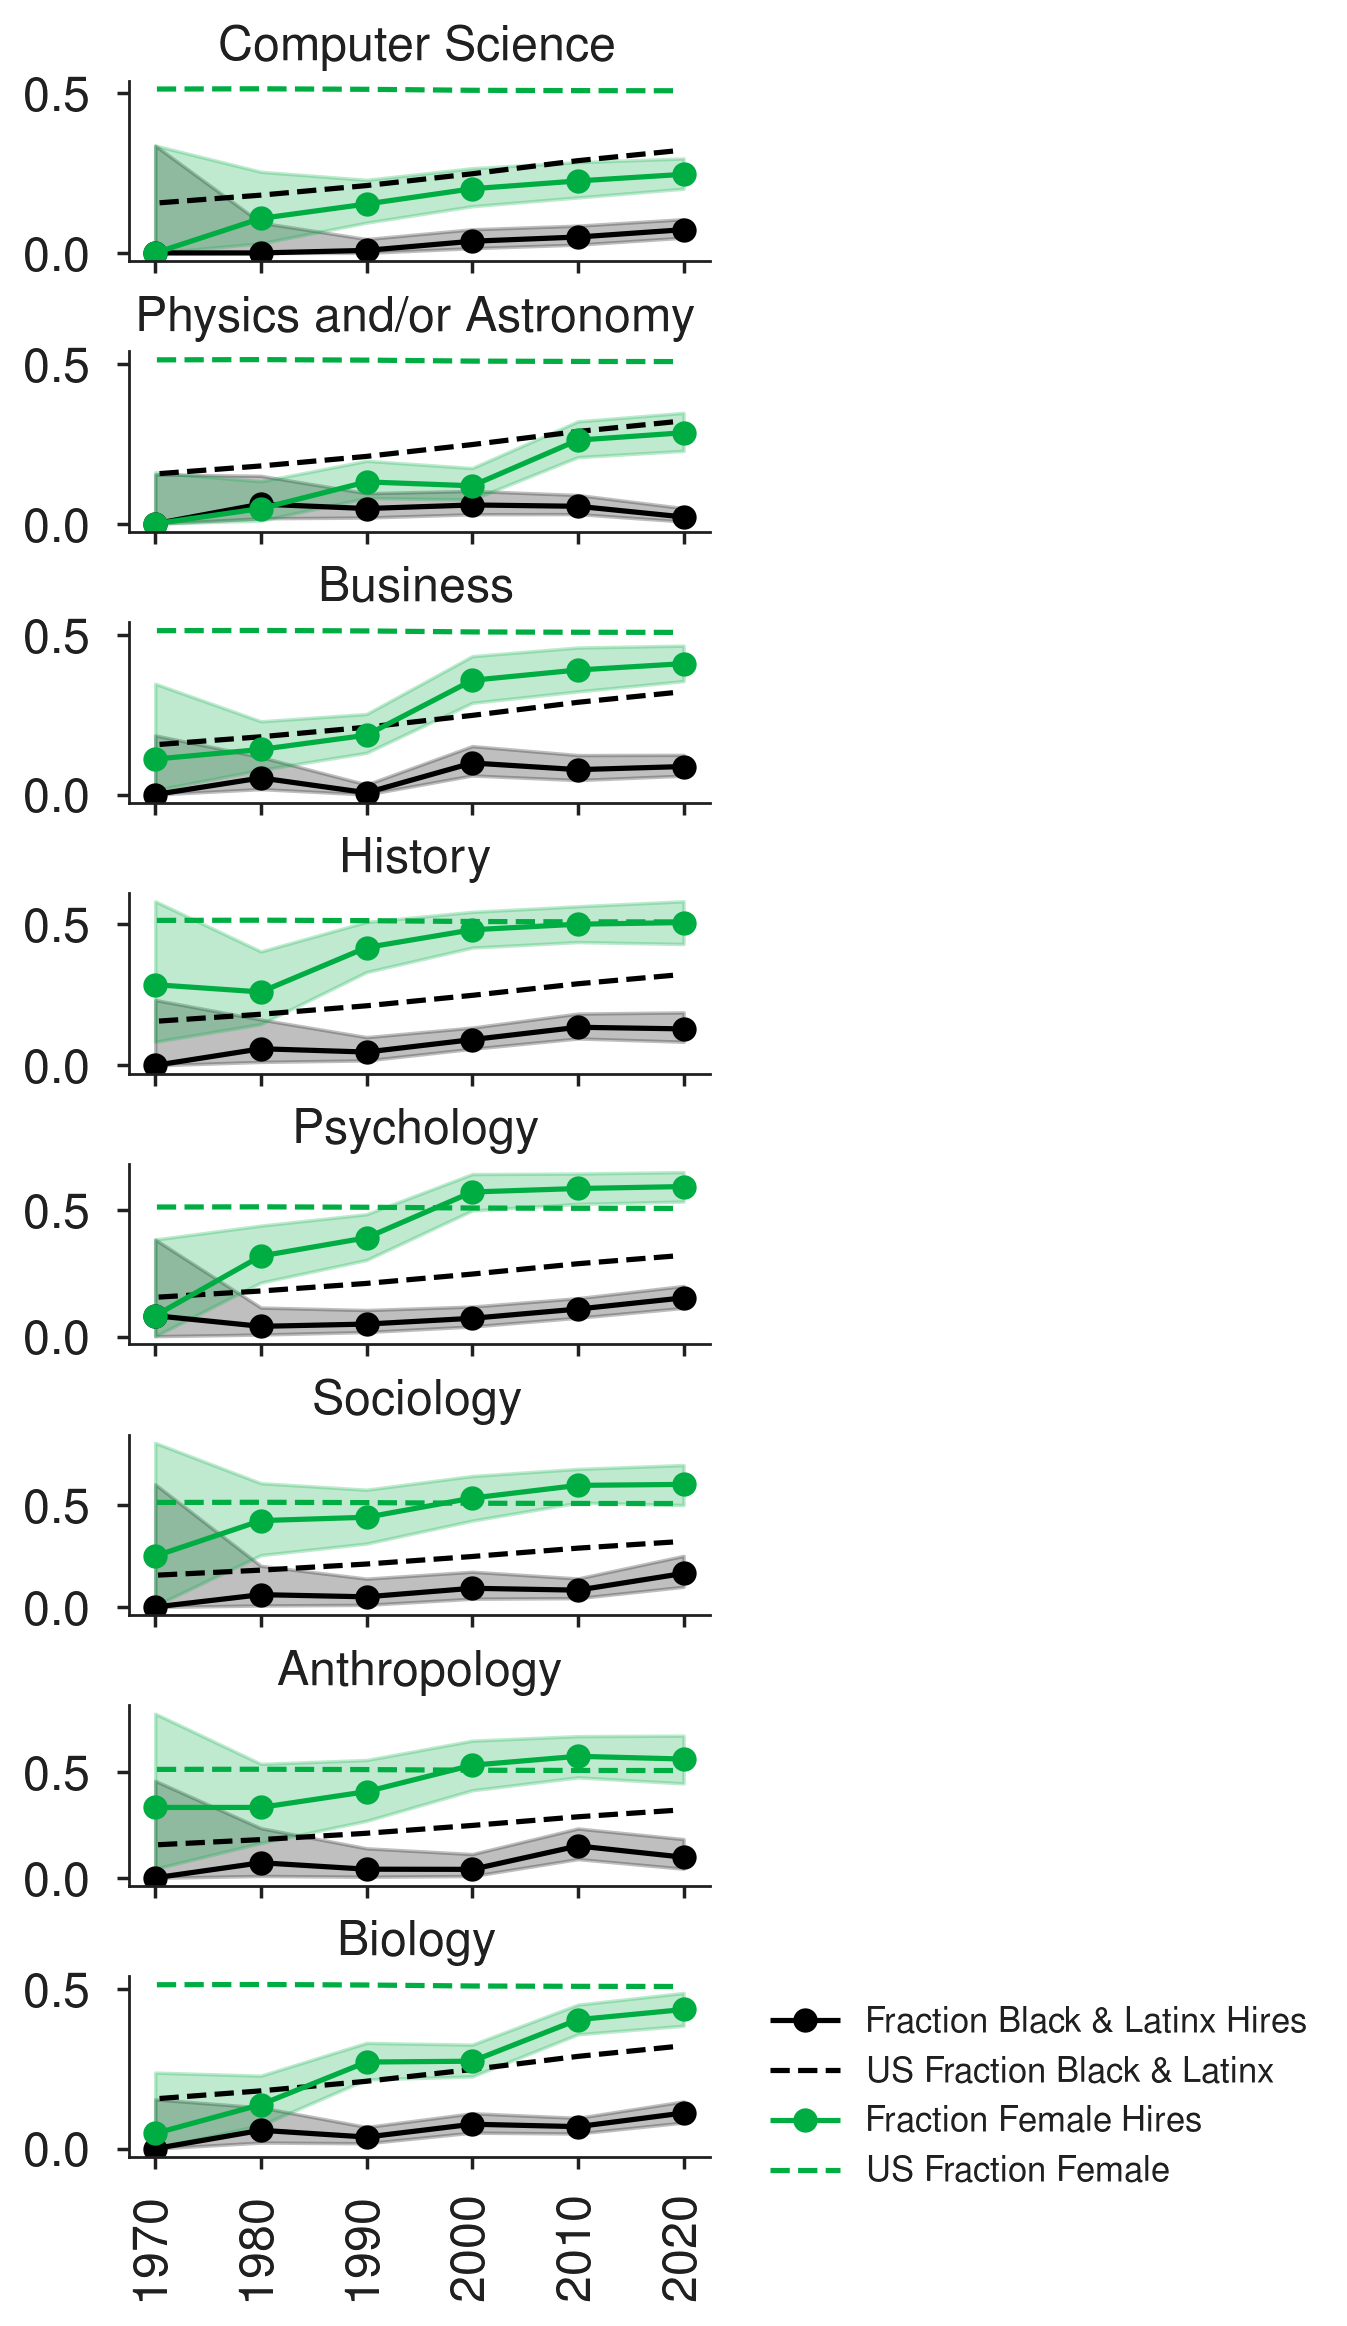

In [61]:
time_col = 'Tenure Track Year'#'Birth Year'
bin_start_decade = 1960
bin_end_decade = 2020
time_bins = [x*10 + bin_start_decade  for x in range(int((bin_end_decade - bin_start_decade)/10)+1)]
alpha = 0.25
z_alpha = 1.96
i = 0

fields = ['Computer Science', 'Physics and/or Astronomy', 'Business', 'History', 'Psychology', 
          'Sociology', 'Anthropology', 'Biology']
fig, ax = plt.subplots(ncols=1, nrows=len(fields), sharex=True, figsize=(3,11), dpi = 250,)
for field in fields:
    #configure race data
    field_df = df[df['likely_department'] == field].copy()
    cats, bins = pd.cut(field_df[time_col], time_bins, retbins=True)
    field_df['cats'] = cats # categories, meow
    plot_data = field_df.groupby('cats')['poc2'].agg(['mean','count', binomial_confidence_interval])
    plot_data = plot_data.reset_index()
    bounds = plot_data['binomial_confidence_interval'].apply(pd.Series)

    #Make the plot
    ax[i].plot(bins[1:], plot_data['mean'], 'k-', marker = 'o',label = 'Fraction Black \& Latinx Hires')
    ax[i].fill_between(bins[1:], bounds[0], bounds[1], alpha=alpha, 
                       color = 'black')

    ax[i].plot(census_race_data['Year'],census_race_data['Frac Black and Hisp'], ls = '--' ,
               label = 'US Fraction Black \& Latinx', color = 'black')

    #configure gender data
    field_df = df[df['likely_department'] == field].copy()
    cats, bins = pd.cut(field_df[time_col], time_bins, retbins=True)
    field_df['cats'] = cats # categories, meow
    plot_data = field_df.groupby('cats')['female'].agg(['mean','count', binomial_confidence_interval])
    plot_data = plot_data.reset_index()
    bounds = plot_data['binomial_confidence_interval'].apply(pd.Series)

    #Make the plot
    ax[i].plot(bins[1:], plot_data['mean'], 'k-', marker = 'o',color = plot_utils.ACCENT_COLOR,
               label = 'Fraction Female Hires',)
    ax[i].fill_between(bins[1:], bounds[0], bounds[1], alpha=alpha, 
                       color = plot_utils.ACCENT_COLOR)

    ax[i].plot(census_gender_data['Year'],census_gender_data['Frac Female'], ls = '--' ,
               label = 'US Fraction Female', color = plot_utils.ACCENT_COLOR)

    
    ax[i].set_title(field, size = plot_utils.LABEL_SIZE)
    plot_utils.finalize(ax[i])
    i += 1
    
    
plt.xticks(time_bins[1:], rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', frameon=False)
plt.subplots_adjust(hspace=.5)

plt.savefig('../plots/demographic_trends.pdf', dpi=1000)